In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import json

# Load optimization results
with open('../data/optimization_results.json', 'r') as f:
    results = json.load(f)

# Simulation inputs loaded from Phase 4
OPTIMIZED_SAFETY_STOCK = results['safety_stock']
OPTIMIZED_ROP = results['reorder_point']
AVG_WEEKLY_DEMAND = results['avg_weekly_demand']
UNIT_PRICE = results.get('unit_price', 120)

# Assumptions (Standard Logistics Industry Metrics)
HOLDING_COST_PCT = 0.20    # It costs 20% of the item's value to store it for a year
STOCKOUT_COST_FIXED = 50   # Cost of losing a customer (penalty) per missed unit

print(f"Simulation initialized for Product Price: ${UNIT_PRICE}")

Simulation initialized for Product Price: $327.62886597938143


In [2]:
# Calculate annual costs

# SCENARIO A: The "Reactive" Approach (No Safety Stock)
# If they have no buffer, they likely stock out whenever lead time spikes.
# Let's assume they stock out 5% of the time (based on lead time variance).
est_missed_sales_A = AVG_WEEKLY_DEMAND * 52 * 0.05  # Miss 5% of yearly demand
cost_stockout_A = est_missed_sales_A * (UNIT_PRICE + STOCKOUT_COST_FIXED)
cost_holding_A = 0 # They hold nothing extra

total_cost_A = cost_stockout_A + cost_holding_A

# SCENARIO B: "Optimized" Approach
# We hold Safety Stock, so stockouts are effectively 0 (95% service level covers us).
est_missed_sales_B = 0
cost_stockout_B = 0

# But we pay to store that safety stock all year
cost_holding_B = OPTIMIZED_SAFETY_STOCK * UNIT_PRICE * HOLDING_COST_PCT

total_cost_B = cost_stockout_B + cost_holding_B

# The results
savings = total_cost_A - total_cost_B
roi = (savings / total_cost_B) * 100

print(f"Current Annual Cost (Estimated): ${total_cost_A:,.2f}")
print(f"Optimized Annual Cost: ${total_cost_B:,.2f}")
print(f"NET SAVINGS:  ${savings:,.2f}")

Current Annual Cost (Estimated): $6,381.02
Optimized Annual Cost: $1,161.05
NET SAVINGS:  $5,219.97


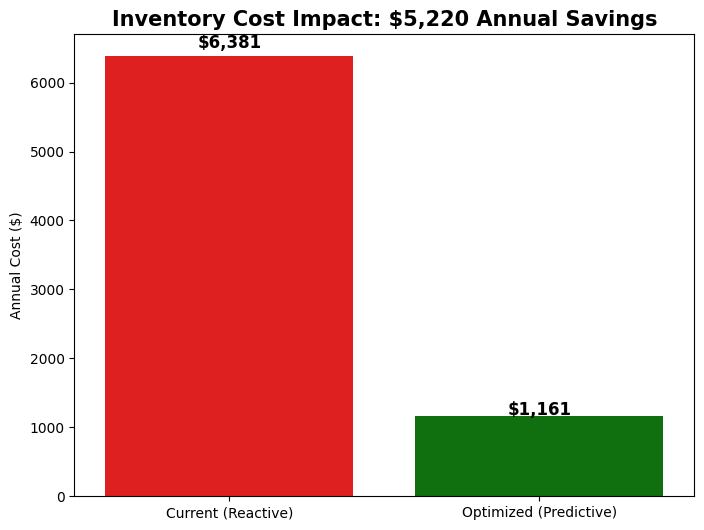

Simulating 90 days of inventory levels...


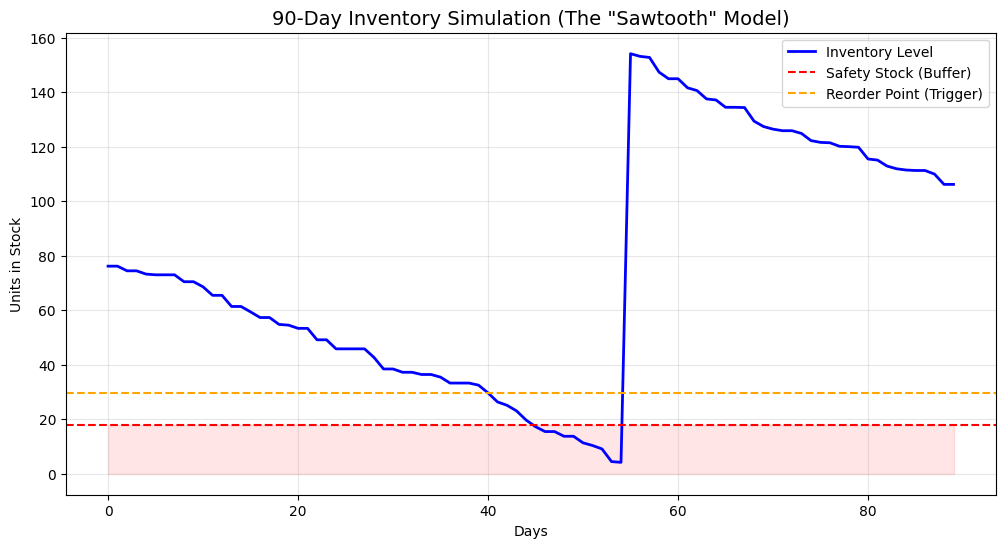

In [3]:
costs = pd.DataFrame({
    'Scenario': ['Current (Reactive)', 'Optimized (Predictive)'],
    'Total Cost': [total_cost_A, total_cost_B],
    'Type' : ['High Risk', 'Balanced']
})

plt.figure(figsize=(8, 6))
ax = sns.barplot(data=costs, x='Scenario', y='Total Cost', hue='Scenario', palette=['red', 'green'], legend=False)

plt.title(f'Inventory Cost Impact: ${savings:,.0f} Annual Savings', fontsize=15, fontweight='bold')
plt.ylabel('Annual Cost ($)')
plt.xlabel('')

for i, v in enumerate(costs['Total Cost']):
    ax.text(i, v + (v*0.02), f"${v:,.0f}", ha='center', fontweight='bold', fontsize=12)

plt.savefig('../results/figures/cost_comparison.png', bbox_inches='tight')
plt.show()

# --- 5. The "Sawtooth" Simulation (Operational Proof) ---

# Simulation Parameters
days = 90
current_stock = OPTIMIZED_ROP + 50  # Start with healthy stock
lead_time_days = 15                 # Approx 2 weeks shipping
order_quantity = 150                # How much we buy when we reorder

# tracking lists for the plot
inventory_history = []
days_range = range(days)
pending_orders = [] # Tracks when new stock will arrive

print(f"Simulating {days} days of inventory levels...")

for day in days_range:
    # 1. Morning: Check for arriving shipments
    # If we have an order scheduled to arrive today, add it to stock
    if len(pending_orders) > 0 and pending_orders[0] == day:
        current_stock += order_quantity
        pending_orders.pop(0) # Remove from list
    
    # 2. Daily Operations: Subtract Demand (Randomized slightly around average)
    # We use a normal distribution to make it look 'real'
    daily_demand = np.random.normal(AVG_WEEKLY_DEMAND / 7, 2) 
    current_stock -= max(0, daily_demand) # Can't have negative demand
    
    # 3. Evening: Check Reorder Point
    # If stock is low AND we don't already have an order on the way
    if current_stock <= OPTIMIZED_ROP and len(pending_orders) == 0:
        arrival_day = day + lead_time_days
        if arrival_day < days:
            pending_orders.append(arrival_day)
    
    # Record the level
    inventory_history.append(current_stock)

# --- 6. Plot the Simulation ---
plt.figure(figsize=(12, 6))
plt.plot(days_range, inventory_history, label='Inventory Level', color='blue', linewidth=2)

# Add Lines for Safety Stock and ROP
plt.axhline(y=OPTIMIZED_SAFETY_STOCK, color='red', linestyle='--', label='Safety Stock (Buffer)')
plt.axhline(y=OPTIMIZED_ROP, color='orange', linestyle='--', label='Reorder Point (Trigger)')

# Formatting
plt.title('90-Day Inventory Simulation (The "Sawtooth" Model)', fontsize=14)
plt.xlabel('Days')
plt.ylabel('Units in Stock')
plt.legend()
plt.grid(True, alpha=0.3)
plt.fill_between(days_range, 0, OPTIMIZED_SAFETY_STOCK, color='red', alpha=0.1) # Highlight danger zone

plt.savefig('../results/figures/inventory_simulation.png', bbox_inches='tight')
plt.show()